# Surface ageostrophic velocity and Ekman dynamics

## Compute geostrophic velocity

In [1]:
import numpy as np
import xarray as xr
import xmitgcm
import xgcm
import glob
from os.path import expanduser,join
import sys
user_home_dir = expanduser('~')
sys.path.append(join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore")

sys.path.append(join(user_home_dir,'Documents','ECCO','ECCO_tutorials'))  # change to path where ecco_po_tutorials module is
from ecco_po_tutorials import *

denspress_monthly_shortname = "ECCO_L4_DENS_STRAT_PRESS_LLC0090GRID_MONTHLY_V4R4"
vel_monthly_shortname = "ECCO_L4_OCEAN_VEL_LLC0090GRID_MONTHLY_V4R4"

# locate files to load
download_root_dir = join(user_home_dir,'Downloads','ECCO_V4r4_PODAAC')
download_dir = join(download_root_dir,denspress_monthly_shortname)
curr_denspress_files = list(glob.glob(join(download_dir,'*nc')))

In [2]:
# locate files to load
download_root_dir = join(user_home_dir,'Downloads','ECCO_V4r4_PODAAC')
download_dir = join(download_root_dir,vel_monthly_shortname)
curr_vel_files = list(glob.glob(join(download_dir,'*nc')))

print(f'number of files to load: {len(curr_vel_files)}')

# load file into workspace
# (in this case only 1 file, but this function can load multiple netCDF files with compatible dimensions)
ds_vel_mo = xr.open_mfdataset(curr_vel_files, parallel=True, data_vars='minimal',\
                                  coords='minimal', compat='override')

# check the variables and their associated units
ds_vel_mo

number of files to load: 1


<xarray.Dataset>
Dimensions:    (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50, k_l: 50, k_p1: 51, tile: 13, time: 1, nv: 2, nb: 4)
Coordinates: (12/22)
  * i          (i) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j          (j) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k          (k) int32 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_u        (k_u) int32 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
    ...         ...
    Zu         (k_u) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    Zl         (k_l) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    time_bnds  (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    XC_bnds    (tile, j, i, nb) float32 dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    YC_bnds    (tile, j, i, nb) float32 dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    Z_bnds     (k, nv) float32 dask.array<chunksize=(50, 2), meta=np.ndarray>
Dimensions without coordinates: nv, nb
Data variables:
    UVEL       (time, k, tile, j, i_g) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    VVEL       (time, k, tile, j_g, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    WVEL       (time, k_l, tile, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
Attributes: (12/62)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    time_coverage_duration:          P1M
    time_coverage_end:               2000-02-01T00:00:00
    time_coverage_resolution:        P1M
    time_coverage_start:             2000-01-01T00:00:00
    title:                           ECCO Ocean Velocity - Monthly Mean llc90...
    uuid:                            32bd652c-4182-11eb-bd5c-0cc47a3f82e7

In [3]:
grid_params_shortname = "ECCO_L4_GEOMETRY_LLC0090GRID_V4R4"
grid_params_filename = "GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc"
grid_params_file = join(download_root_dir,grid_params_shortname,grid_params_filename)

# load grid parameters file
ds_grid = xr.open_dataset(grid_params_file)


# compute geostrophic velocities for upper 2 layers of output
dict_subset = {'k':[0,1]}
ds_grid = ds_grid.isel({'k':[0,1],'k_l':[0,1],'k_u':[0,1],'k_p1':[0,1,2]})
ds_geos_vel = geos_vel_compute(curr_denspress_files[0],grid_filename=grid_params_file,subset=dict_subset)
u_g = ds_geos_vel.u_g
v_g = ds_geos_vel.v_g

ds_vel = ds_vel_mo.isel(dict_subset)

grid = ecco.get_llc_grid(ds_grid)
vel_interp = grid.interp_2d_vector({'X':ds_vel.UVEL,'Y':ds_vel.VVEL})
u_interp = vel_interp['X']
v_interp = vel_interp['Y']

## Ageostrophic velocity orientation

In [8]:
# difference between actual and geostrophic velocity vectors (in complex plane)

u_diff = u_interp - u_g
v_diff = v_interp - v_g
vel_diff_complex = u_diff + (1j*v_diff)    # in Python, imaginary number i is indicated by 1j
vel_complex = u_interp + (1j*v_interp)

# normalize magnitude of difference vector by magnitude of actual velocity
vel_diff_abs = np.abs(vel_diff_complex)
vel_abs = np.abs(vel_complex)
vel_diff_norm = vel_diff_abs/vel_abs

# direction angle of ageostrophic velocity
co = np.expand_dims(ds_grid.CS,axis=(0,1))
si = np.expand_dims(ds_grid.SN,axis=(0,1))
u_east_diff = (co*u_diff) - (si*v_diff)
v_north_diff = (si*u_diff) + (co*v_diff)
vel_diff_complex_axiscorrected = u_east_diff + (1j*v_north_diff)
direction_angle_ageostr = np.imag(np.log(vel_diff_complex_axiscorrected))   # direction angle (0=eastward,pi/2=northward)

# k index (depth level) to plot
k_plot = 1

depth_str = str(int(-ds_grid.Z.isel(k=k_plot)))

# colormap with NaN masking
seismic_nanmasked = plt.get_cmap('seismic').copy()
seismic_nanmasked.set_bad('black')
twilight_nanmasked = plt.get_cmap('twilight').copy()
twilight_nanmasked.set_bad('black')

-179.875 112.875
-180.0 113.0
-89.875 89.875
-90.0 90.0
113.12547814606742 179.87453185393258
113.00001 180.0
-89.875 89.875
-90.0 90.0


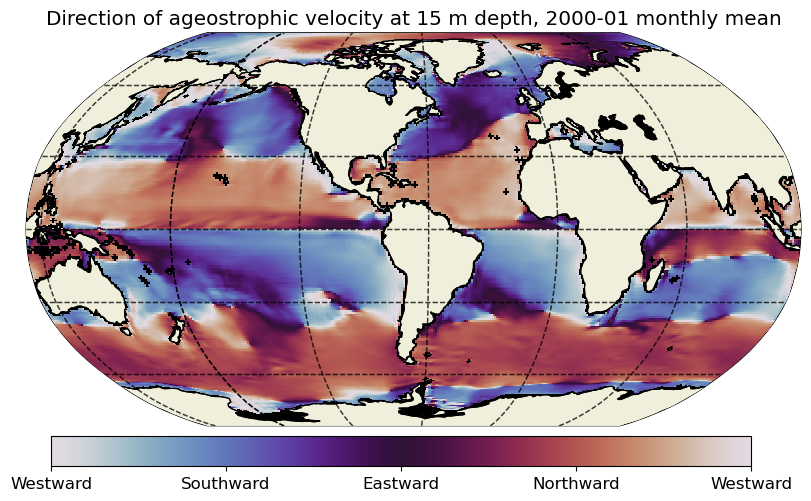

-179.875 112.875
-180.0 113.0
-89.875 89.875
-90.0 90.0
113.12547814606742 179.87453185393258
113.00001 180.0
-89.875 89.875
-90.0 90.0


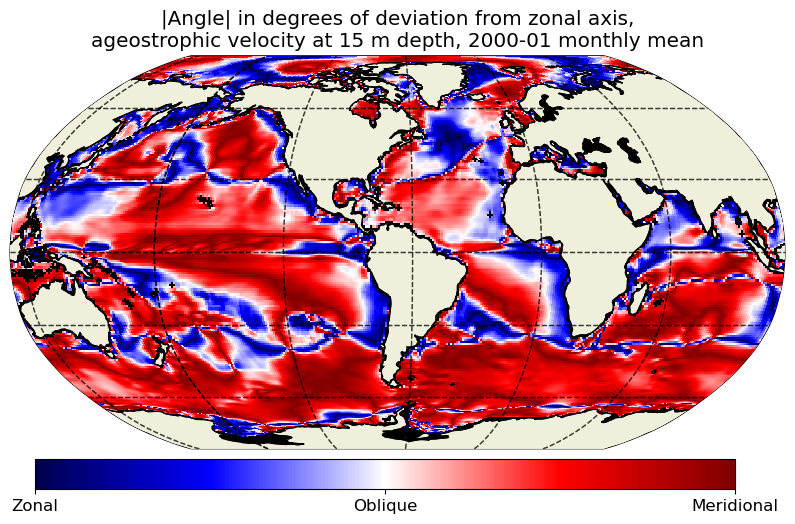

In [17]:
plt.rcParams["font.size"] = 12    # set default font size

time_month_str = str(ds_vel.time.values[0])[:7]


# plot figures

curr_obj = ecco.plot_proj_to_latlon_grid(ds_grid.XC,ds_grid.YC,\
                                        direction_angle_ageostr.isel(k=k_plot).squeeze(),\
                                        cmin=-np.pi,cmax=np.pi,cmap=twilight_nanmasked,show_colorbar=False,\
                                        show_land=True,projection_type='robin',\
                                        user_lon_0=-67,plot_type='pcolormesh')
curr_fig = curr_obj[0]
curr_ax = curr_obj[1]
curr_fig.set_figwidth(10)
curr_fig.set_figheight(6)

# add colorbar with correct scaling
cbar_ax = curr_fig.add_axes([0.15,0.1,0.7,0.05])
import matplotlib.colors as colors
cbar = curr_fig.colorbar(plt.cm.ScalarMappable(\
                           norm=colors.Normalize(vmin=-np.pi,vmax=np.pi),\
                           cmap=twilight_nanmasked),cax=cbar_ax,orientation='horizontal')
cbar.set_ticks(ticks=[-np.pi,-np.pi/2,0,np.pi/2,np.pi],\
               labels=['Westward','Southward','Eastward','Northward','Westward'])

# add title
curr_ax.set_title('Direction of ageostrophic velocity at ' + depth_str + ' m depth, '\
                  + time_month_str + ' monthly mean')

plt.savefig('Ageostr_vel_dir_global_' + depth_str + 'm_depth_' + time_month_str + '_monmean.png')
plt.show()



angle_dev_from_zonal = (np.pi/2) - np.abs((direction_angle_ageostr % np.pi) - (np.pi/2))

curr_obj = ecco.plot_proj_to_latlon_grid(ds_grid.XC,ds_grid.YC,\
                                        (180/np.pi)*angle_dev_from_zonal.isel(k=k_plot).squeeze(),\
                                        cmin=0,cmax=90,cmap=seismic_nanmasked,show_colorbar=False,\
                                        show_land=True,projection_type='robin',\
                                        user_lon_0=-67,plot_type='pcolormesh')
curr_fig = curr_obj[0]
curr_ax = curr_obj[1]
curr_fig.set_figwidth(10)
curr_fig.set_figheight(6)

# add colorbar with correct scaling
cbar_ax = curr_fig.add_axes([0.15,0.1,0.7,0.05])
cbar = curr_fig.colorbar(plt.cm.ScalarMappable(\
                           norm=colors.Normalize(vmin=0,vmax=90),\
                           cmap=seismic_nanmasked),cax=cbar_ax,orientation='horizontal')
cbar.set_ticks(ticks=[0,45,90],labels=['Zonal','Oblique','Meridional'])

# add title
curr_ax.set_title('|Angle| in degrees of deviation from zonal axis,\n'\
                  + 'ageostrophic velocity at ' + depth_str + ' m depth, '+ time_month_str + ' monthly mean')

plt.savefig('Ageostr_vel_angle_from_zonal_global_' + depth_str + 'm_depth_' + time_month_str + '_monmean.png')
plt.show()

## Near-surface ageostrophic velocity vs. surface stress

In [6]:
# # Now load and do calculations with ocean surface stress

stress_monthly_shortname = "ECCO_L4_STRESS_LLC0090GRID_MONTHLY_V4R4"

download_root_dir = join(user_home_dir,'Downloads','ECCO_V4r4_PODAAC')
download_dir = join(download_root_dir,stress_monthly_shortname)
curr_stress_files = list(glob.glob(join(download_dir,'*nc')))

# load file into workspace
# (in this case only 1 file, but this function can load multiple netCDF files with compatible dimensions)
ds_stress_mo = xr.open_mfdataset(curr_stress_files, parallel=True, data_vars='minimal',\
                                  coords='minimal', compat='override')

oceTAUX = ds_stress_mo.oceTAUX.expand_dims(dim={'k':np.array([0,1])},axis=1)
oceTAUY = ds_stress_mo.oceTAUY.expand_dims(dim={'k':np.array([0,1])},axis=1)

In [14]:
direction_angle_ageostr

<xarray.DataArray (time: 1, k: 2, tile: 13, j: 90, i: 90)>
dask.array<imag, shape=(1, 2, 13, 90, 90), dtype=float32, chunksize=(1, 2, 1, 90, 90), chunktype=numpy.ndarray>
Coordinates:
  * k        (k) int64 0 1
  * time     (time) datetime64[ns] 2000-01-16T12:00:00
  * i        (i) int32 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * j        (j) int32 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * tile     (tile) int32 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (tile, j, i) float32 -111.6 -111.3 -110.9 ... -99.42 -105.6 -111.9
    YC       (tile, j, i) float32 -88.24 -88.38 -88.52 ... -88.03 -88.08 -88.1
    Z        (k) float32 -5.0 -15.0

-179.875 112.875
-180.0 113.0
-89.875 89.875
-90.0 90.0
113.12547814606742 179.87453185393258
113.00001 180.0
-89.875 89.875
-90.0 90.0


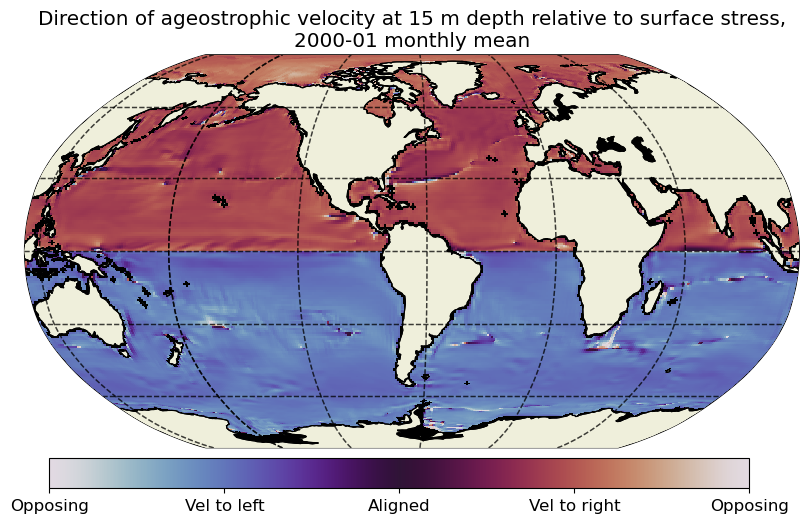

-179.875 112.875
-180.0 113.0
-89.875 89.875
-90.0 90.0
113.12547814606742 179.87453185393258
113.00001 180.0
-89.875 89.875
-90.0 90.0


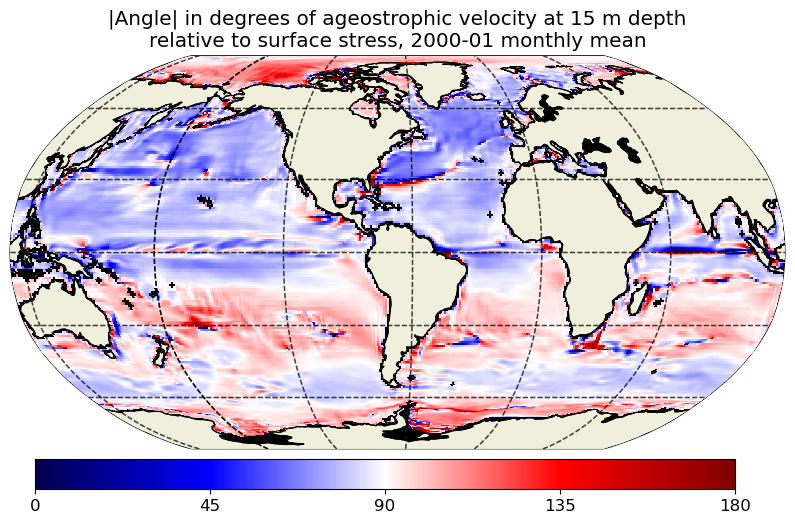

In [18]:
stress_interp = grid.interp_2d_vector({'X':oceTAUX,'Y':oceTAUY})
oceTAUX_interp = stress_interp['X']
oceTAUY_interp = stress_interp['Y']
oceTAUX_interp = oceTAUX_interp.isel(k=[0])
oceTAUY_interp = oceTAUY_interp.isel(k=[0])

oceTAUE = (co*oceTAUX_interp) - (si*oceTAUY_interp)
oceTAUN = (si*oceTAUX_interp) + (co*oceTAUY_interp)

stress_complex = oceTAUE + (1j*oceTAUN)
direction_stress = np.imag(np.log(stress_complex))

# angle difference between ageostrophic velocity and surface stress (positive=velocity to right of stress)
angle_vel_minus_stress = (((-(direction_angle_ageostr - np.tile(direction_stress,(1,len(ds_grid.k),1,1,1))))\
                           + np.pi) % (2*np.pi)) - np.pi



# plot figures

curr_obj = ecco.plot_proj_to_latlon_grid(ds_grid.XC,ds_grid.YC,\
                                        angle_vel_minus_stress.isel(k=k_plot).squeeze(),\
                                        cmin=-np.pi,cmax=np.pi,cmap=twilight_nanmasked,show_colorbar=False,\
                                        show_land=True,projection_type='robin',\
                                        user_lon_0=-67,plot_type='pcolormesh')
curr_fig = curr_obj[0]
curr_ax = curr_obj[1]
curr_fig.set_figwidth(10)
curr_fig.set_figheight(6)

# add colorbar with correct scaling
cbar_ax = curr_fig.add_axes([0.15,0.1,0.7,0.05])
cbar = curr_fig.colorbar(plt.cm.ScalarMappable(\
                           norm=colors.Normalize(vmin=-np.pi,vmax=np.pi),\
                           cmap=twilight_nanmasked),cax=cbar_ax,orientation='horizontal')
cbar.set_ticks(ticks=[-np.pi,-np.pi/2,0,np.pi/2,np.pi],\
               labels=['Opposing','Vel to left','Aligned','Vel to right','Opposing'])

# add title
curr_ax.set_title('Direction of ageostrophic velocity at ' + depth_str + ' m depth relative to surface stress,\n'\
                  + time_month_str + ' monthly mean')

plt.savefig('Ageostr_vel_dir_from_stress_global_' + depth_str + 'm_depth_' + time_month_str + '_monmean.png')
plt.show()



curr_obj = ecco.plot_proj_to_latlon_grid(ds_grid.XC,ds_grid.YC,\
                                        (180/np.pi)*np.abs(angle_vel_minus_stress).isel(k=k_plot).squeeze(),\
                                        cmin=0,cmax=180,cmap=seismic_nanmasked,show_colorbar=False,\
                                        show_land=True,projection_type='robin',\
                                        user_lon_0=-67,plot_type='pcolormesh')
curr_fig = curr_obj[0]
curr_ax = curr_obj[1]
curr_fig.set_figwidth(10)
curr_fig.set_figheight(6)

# add colorbar with correct scaling
cbar_ax = curr_fig.add_axes([0.15,0.1,0.7,0.05])
cbar = curr_fig.colorbar(plt.cm.ScalarMappable(\
                           norm=colors.Normalize(vmin=0,vmax=180),\
                           cmap=seismic_nanmasked),cax=cbar_ax,orientation='horizontal')
cbar.set_ticks(ticks=[0,45,90,135,180])

# add title
curr_ax.set_title('|Angle| in degrees of ageostrophic velocity at ' + depth_str + ' m depth\n'
                  'relative to surface stress, ' + time_month_str + ' monthly mean')

plt.savefig('Ageostr_vel_angle_from_stress_global_' + depth_str + 'm_depth_' + time_month_str + '_monmean.png')
plt.show()